# Etude du Dataset SILICONE


In [1]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline, Trainer, TrainingArguments
from tqdm import tqdm
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
from tasknet import Adapter
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score

from CustomTrainer import CustomTrainer

# Chargement du Dataset SILICONE

In [2]:
# Load SILICONE dataset in its Dyda_da config (only 4 possible dialog acts)

silicone_dyda = load_dataset('silicone', 'dyda_da')
dyda_train = silicone_dyda['train']
dyda_valid = silicone_dyda['validation']
dyda_test = silicone_dyda['test']

Found cached dataset silicone (C:/Users/robin/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dyda_train

Dataset({
    features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
    num_rows: 87170
})

In [4]:
num_labels = 4
labels = ['commissive', 'directive', 'inform', 'question']
id2label = {0: 'commissive',
            1: 'directive', 
            2: 'inform', 
            3: 'question'
}
label2id = {value: key for key, value in id2label.items()}

In [5]:
dyda_train_df = pd.DataFrame.from_dict(dyda_train[:])
dyda_test_df = pd.DataFrame.from_dict(dyda_test[:])
dyda_test_df.head()

,Utterance,Dialogue_Act,Dialogue_ID,Label,Idx
0,"hey man , you wanna buy some weed ?",directive,1,1,0
1,some what ?,question,1,3,1
2,"weed ! you know ? pot , ganja , mary jane some...",directive,1,1,2
3,"oh , umm , no thanks .",commissive,1,0,3
4,i also have blow if you prefer to do a few lin...,directive,1,1,4


# Chargement du modèle préentraîné

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'microsoft/deberta-v3-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, 
    ignore_mismatched_sizes=True,
    num_labels=num_labels, 
    #id2label=id2label, label2id=label2id
).to(device)

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\robin\AppData\Roaming\Python\Python310\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.w

# First Preprocessing

In [7]:
def tokenize_function(example):
    return tokenizer(example["Utterance"], truncation=True, max_length=128)

valid_tkz = dyda_valid.map(tokenize_function, batched=True)
train_tkz = dyda_train.map(tokenize_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/88 [00:00<?, ?ba/s]

In [8]:
train_tkz

Dataset({
    features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 87170
})

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

samples = train_tkz[:8]
samples = {k: v for k, v in samples.items() if k not in ["Utterance", "Dialogue_Act", "Idx", "Dialogue_ID"]}
[len(x) for x in samples["input_ids"]]

[16, 16, 14, 27, 24, 23, 32, 31]

In [10]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Label': torch.Size([8]),
 'input_ids': torch.Size([8, 32]),
 'token_type_ids': torch.Size([8, 32]),
 'attention_mask': torch.Size([8, 32])}

In [11]:
train_sample = train_tkz[:200]
train_sample = {k: v for k, v in train_sample.items() if k not in ["Utterance", "Dialogue_Act", "Idx", "Dialogue_ID"]}

valid_sample = valid_tkz[:100]
valid_sample = {k: v for k, v in valid_sample.items() if k not in ["Utterance", "Dialogue_Act", "Idx", "Dialogue_ID"]}

# Preprocessing V2

In [7]:
# build smaller dataset

dyda_train_sample = dyda_train[:2000]
dyda_valid_sample = dyda_valid[:200]
dyda_test_sample = dyda_test[:500]

In [8]:
train_inputs = tokenizer(dyda_train_sample['Utterance'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
valid_inputs = tokenizer(dyda_valid_sample['Utterance'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
test_inputs = tokenizer(dyda_test_sample['Utterance'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')

#train_labels = tokenizer(dyda_train['Dialogue_Act'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
#valid_labels = tokenizer(dyda_valid['Dialogue_Act'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')

In [9]:
train_inputs

{'input_ids': tensor([[   1,  504,  366,  ...,    0,    0,    0],
        [   1,  274,  391,  ...,    0,    0,    0],
        [   1,  339,  333,  ...,    0,    0,    0],
        ...,
        [   1, 2163, 1570,  ...,    0,    0,    0],
        [   1,  339,  333,  ...,    0,    0,    0],
        [   1,  584,  507,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [10]:
# Create a TensorDataset from the input data and labels
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_inputs['token_type_ids'], torch.tensor(dyda_train_sample['Label']))
valid_dataset = TensorDataset(valid_inputs['input_ids'], valid_inputs['attention_mask'], valid_inputs['token_type_ids'], torch.tensor(dyda_valid_sample['Label']))
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_inputs['token_type_ids'], torch.tensor(dyda_test_sample['Label']))

# Create DataLoader objects for the training and validation sets
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=16)

# Training

In [11]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mnli")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
# define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=20,
    save_total_limit=2,
    save_steps=50
)

# define the trainer object
trainer = CustomTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=train_dataset,            # training dataset
    eval_dataset=valid_dataset,               # evaluation dataset
    #compute_metrics=lambda pred, labels: {"accuracy": accuracy_score(labels, pred.argmax(axis=1))},
    compute_metrics=compute_metrics,
    #data_collator=data_collator,
    #tokenizer=tokenizer,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'token_type_ids': torch.stack([item[2] for item in data]),
                                'labels': torch.tensor([item[3] for item in data])},
)

# start the training process
trainer.train()

C:\Users\robin\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 375
  Number of trainable parameters = 184425220


Step,Training Loss,Validation Loss,Accuracy
20,1.407000,1.402739,0.105000
40,1.344200,1.328071,0.295000
60,1.187400,1.199666,0.520000
80,0.946200,1.097594,0.450000
100,0.771700,0.827593,0.660000
120,0.407800,0.781659,0.665000
140,0.473800,0.749783,0.670000
160,0.410200,0.821458,0.675000
180,0.439000,0.672847,0.675000
200,0.281000,0.649217,0.680000


***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to ./results\checkpoint-50
Configuration saved in ./results\checkpoint-50\config.json
Model weights saved in ./results\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
Saving model checkpoint to ./results\checkpoint-100
Configuration saved in ./results\checkpoint-100\config.json
Model weights saved in ./results\checkpoint-100\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 64
***** Running Evaluation *****
  Num examples = 200
  Batch size = 

TrainOutput(global_step=375, training_loss=0.5746721134185792, metrics={'train_runtime': 5691.9564, 'train_samples_per_second': 1.054, 'train_steps_per_second': 0.066, 'total_flos': 394680748032000.0, 'train_loss': 0.5746721134185792, 'epoch': 3.0})

# Prediction

In [25]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 200
  Batch size = 64


Labels found
tensor(0.4939)


Labels found
tensor(0.7058)
Labels found
tensor(1.0218)
Labels found
tensor(0.2191)
(200, 4) (200,)


In [26]:
accuracy = evaluate.load("accuracy")
accuracy.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.63}

In [13]:

test_inputs_full = tokenizer(dyda_test['Utterance'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
test_dataset = TensorDataset(test_inputs_full['input_ids'], test_inputs_full['attention_mask'], test_inputs_full['token_type_ids'], torch.tensor(dyda_test['Label']))

In [14]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 7740
  Batch size = 64


NameError: name 'accuracy' is not defined

In [15]:
accuracy = evaluate.load("accuracy")

accuracy.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.7595607235142119}

# Evaluation

In [27]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 64


Labels found
tensor(0.6135)


Labels found
tensor(0.7651)
Labels found
tensor(0.6277)
Labels found
tensor(0.4445)


{'eval_loss': 0.659791111946106,
 'eval_accuracy': 0.68,
 'eval_runtime': 42.0975,
 'eval_samples_per_second': 4.751,
 'eval_steps_per_second': 0.095,
 'epoch': 3.0}

In [15]:
# Prediction

#model_inputs_test = tokenizer(dyda_test_sample['Utterance'], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
model_inputs_test = test_inputs['input_ids'].tolist()
preds = []
for input in model_inputs_test:
    pred = model(torch.tensor([input]))
    preds.append(pred)
#preds = model(model_inputs_test)

In [16]:
print(preds[:5])

[SequenceClassifierOutput(loss=None, logits=tensor([[-0.1522, -0.1729,  0.0872,  0.0323]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None), SequenceClassifierOutput(loss=None, logits=tensor([[-0.2559, -0.1825, -0.1750,  0.0066]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None), SequenceClassifierOutput(loss=None, logits=tensor([[-0.3809, -0.1858, -0.0521,  0.0344]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None), SequenceClassifierOutput(loss=None, logits=tensor([[-0.3262, -0.0846, -0.0612, -0.0484]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None), SequenceClassifierOutput(loss=None, logits=tensor([[-0.2262, -0.1908,  0.0267, -0.0462]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)]


In [1]:
# Evaluation

trainer = CustomTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=train_dataset,            # training dataset
    eval_dataset=valid_dataset,               # evaluation dataset
    #compute_metrics=lambda pred, labels: {"accuracy": accuracy_score(labels, pred.argmax(axis=1))},
    #data_collator=data_collator,
    #tokenizer=tokenizer,
    data_collator=lambda data: {'input_ids': torch.stack([item[0] for item in data]),
                                'attention_mask': torch.stack([item[1] for item in data]),
                                'token_type_ids': torch.stack([item[2] for item in data]),
                                'labels': torch.tensor([item[3] for item in data])},
)

trainer.predict(test_dataset)

NameError: name 'CustomTrainer' is not defined

In [18]:
steps = [
    20,
    40,
    60,
    80,
    100,
    120,
    140,
    160,
    180,
    200,
    220,
    240,
    260,
    280,
    300,
    320,
    340,
    360,
]

training_loss = [
    1.407000,
    1.344200,
    1.187400,
    0.946200,
    0.771700,
    0.407800,
    0.473800,
    0.410200,
    0.439000,
    0.281000,
    0.337600,
    0.322300,
    0.241900,
    0.228000,
    0.346200,
    0.350300,
    0.443300,
    0.334600,
]

validation_loss = [
    1.402739,
    1.328071,
    1.199666,
    1.097594,
    0.827593,
    0.781659,
    0.749783,
    0.821458,
    0.672847,
    0.649217,
    0.684714,
    0.650497,
    0.739996,
    0.537463,
    0.657043,
    0.675720,
    0.458712,
    0.553084,
]

validation_accuracy = [
    0.105000,
    0.295000,
    0.520000,
    0.450000,
    0.660000,
    0.665000,
    0.670000,
    0.675000,
    0.675000,
    0.680000,
    0.675000,
    0.685000,
    0.705000,
    0.740000,
    0.685000,
    0.725000,
    0.740000,
    0.700000,
]

C:\Users\robin\AppData\Local\Temp\ipykernel_18464\3252364304.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(steps, training_loss, 'b', label='Training Loss', color='red')
C:\Users\robin\AppData\Local\Temp\ipykernel_18464\3252364304.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(steps, validation_loss, 'b', label='Validation Loss', color='blue')


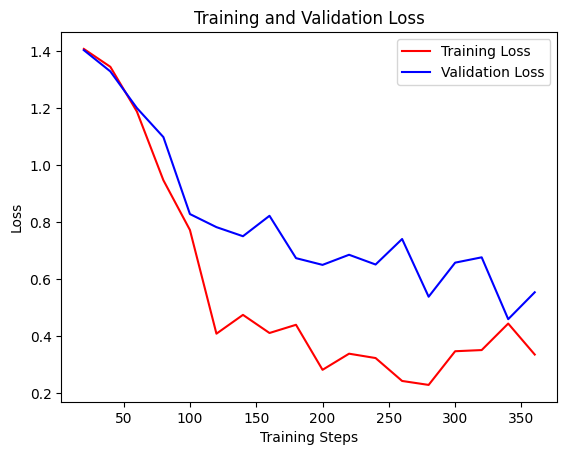

In [19]:
import matplotlib.pyplot as plt

plt.plot(steps, training_loss, 'b', label='Training Loss', color='red')
plt.plot(steps, validation_loss, 'b', label='Validation Loss', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/deberta_fine_tuning_2000_20.jpg')
plt.show()

C:\Users\robin\AppData\Local\Temp\ipykernel_18464\3160457646.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(train_sizes, accuracies, 'b', label='Accuracy', color='red')


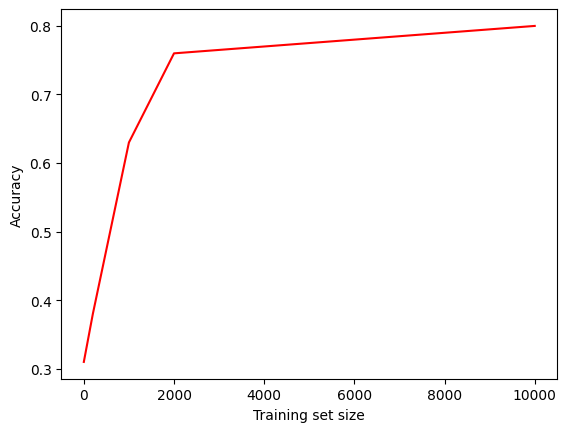

In [26]:
accuracies = [0.31, 0.38, 0.63, 0.76, 0.80]
train_sizes = [0, 200, 1000, 2000, 10000]


plt.plot(train_sizes, accuracies, 'b', label='Accuracy', color='red')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.savefig('plots/deberta_test_accuracies.jpg')
plt.show()

In [ ]:
# Model explainability (confusion matrix) ?